In [1]:
# for loading/processing the images
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [2]:
path = r"/Users/damlas/Desktop/SeeGrass/images1"
os.chdir(path)

# this list holds all the image filename
seagrasses = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.tif'):
          # adds only the image files to the flowers list
            seagrasses.append(file.name)

In [3]:
seagrasses


['2019_07_31_ci2c1.tif',
 '2020_01_19_cs2b1.tif',
 '2020_01_19_cd3a1.tif',
 '2019_09_25_cd2b2.tif',
 '2019_09_25_cs3a2.tif',
 '2019_08_30_cs2l1.tif',
 '2019_08_09_ws3a2.tif',
 '07_31_ci1a1.tif',
 '2019_08_09_wd2b2.tif',
 '12_18_wd2a2.tif',
 '2019_09_11_wd3b5.tif',
 '2019_07_31_cd2g1.tif',
 '2019_07_31_cs3d1.tif',
 '2010_07_31_cs3b2.tif',
 '2019_11_18_ci2b1.tif',
 '09_11_wd2a3.tif',
 '2019_07_31_cd2k2.tif',
 '08_30_PRE_cd1a3.tif',
 '2019_07_31_cs2b1.tif',
 '01_18_cd2a1.tif',
 '2019_08_09_wd1e4.tif',
 '2019_10_09_wm3a4.tif',
 '2019_09_11_ws1f3.tif',
 '2019_08_09_wd3h1.tif',
 '2019_07_31_cm1b3.tif',
 '2019_07_31_ci3e1.tif',
 '2019_08_09_ws2k1.tif',
 '2019_08_30_cd2i1.tif',
 '2019_08_09_wd3d2.tif',
 '11_18_cs1a1.tif',
 '2019_08_09_ws2g2.tif',
 '2019_08_30_cd2e2.tif',
 '2019_08_30_cd2e3.tif',
 '2019_08_09_wd3d3.tif',
 '2019_07_31_cm1b2.tif',
 '2019_09_11_ws1f2.tif',
 '2019_08_30_cs1f1.tif',
 '2019_08_09_wm1g1.tif',
 '2019_08_09_wd1d1.tif',
 '2019_09_11_ws1j1.tif',
 '08_30_PRE_cd1a2.tif',
 '

In [4]:
len(seagrasses)

857

In [5]:
# load the image as a 224x224 array
img = load_img(seagrasses[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

In [6]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

(1, 224, 224, 3)


(1, 224, 224, 3)

In [7]:
x = preprocess_input(reshaped_img)

In [8]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [9]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [10]:
data = {}
p = r"/Users/damlas/Desktop/SeeGrass/images1"

# lop through each image in the dataset
for seagrass in seagrasses:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(seagrass,model)
        data[seagrass] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)


# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the seagrass_labels.csv)
#df = pd.read_csv('seagrass_labels.csv')
#label = df['label'].tolist()
#unique_labels = list(set(label))


2023-12-29 08:30:07.758970: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 145ms/step


In [11]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

Clipping cluster size from 364 to 3


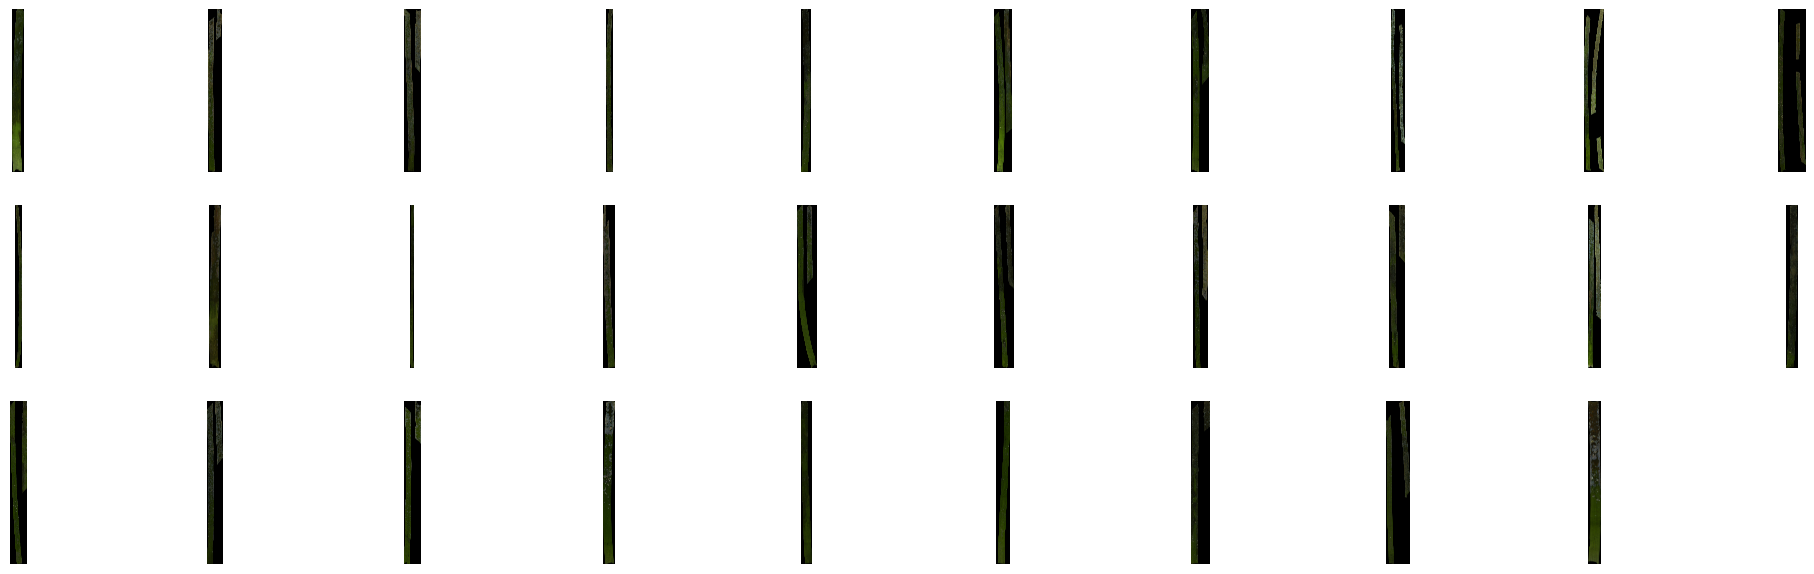

In [12]:
# cluster feature vectors
kmeans = KMeans(n_clusters=3,n_init='auto',random_state=22) #n_init=10,verbose=0,
kmeans.fit(x) # x- feat
y_km = kmeans.fit_predict(x) # x- feat
labels = kmeans.predict(x) # x- feat
# len(unique_labels) , n_jobs=-1
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 3:
        print(f"Clipping cluster size from {len(files)} to 3")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

view_cluster(cluster)

In [13]:
y_km

array([2, 1, 1, 2, 2, 1, 0, 0, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0,
       2, 0, 0, 1, 2, 1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0,
       2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1,
       2, 1, 0, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1,
       0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0,
       1, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 2, 0,
       2, 1, 0, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1,
       1, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 2,
       0, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 2, 2,
       0, 0, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
       0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2,

In [14]:
matchings = {}
for i in range(len(seagrasses)):
  matchings[seagrasses[i]] = str(y_km[i])
print(matchings)

{'2019_07_31_ci2c1.tif': '2', '2020_01_19_cs2b1.tif': '1', '2020_01_19_cd3a1.tif': '1', '2019_09_25_cd2b2.tif': '2', '2019_09_25_cs3a2.tif': '2', '2019_08_30_cs2l1.tif': '1', '2019_08_09_ws3a2.tif': '0', '07_31_ci1a1.tif': '0', '2019_08_09_wd2b2.tif': '2', '12_18_wd2a2.tif': '1', '2019_09_11_wd3b5.tif': '2', '2019_07_31_cd2g1.tif': '0', '2019_07_31_cs3d1.tif': '1', '2010_07_31_cs3b2.tif': '2', '2019_11_18_ci2b1.tif': '0', '09_11_wd2a3.tif': '2', '2019_07_31_cd2k2.tif': '2', '08_30_PRE_cd1a3.tif': '0', '2019_07_31_cs2b1.tif': '2', '01_18_cd2a1.tif': '1', '2019_08_09_wd1e4.tif': '2', '2019_10_09_wm3a4.tif': '0', '2019_09_11_ws1f3.tif': '2', '2019_08_09_wd3h1.tif': '0', '2019_07_31_cm1b3.tif': '0', '2019_07_31_ci3e1.tif': '1', '2019_08_09_ws2k1.tif': '2', '2019_08_30_cd2i1.tif': '1', '2019_08_09_wd3d2.tif': '0', '11_18_cs1a1.tif': '1', '2019_08_09_ws2g2.tif': '2', '2019_08_30_cd2e2.tif': '2', '2019_08_30_cd2e3.tif': '2', '2019_08_09_wd3d3.tif': '2', '2019_07_31_cm1b2.tif': '0', '2019_09_1

In [15]:
#x['labels'] = labels
#x[labels].value_counts()

In [16]:
import numpy as np
np.unique(labels,return_counts=True)

(array([0, 1, 2], dtype=int32), array([272, 221, 364]))

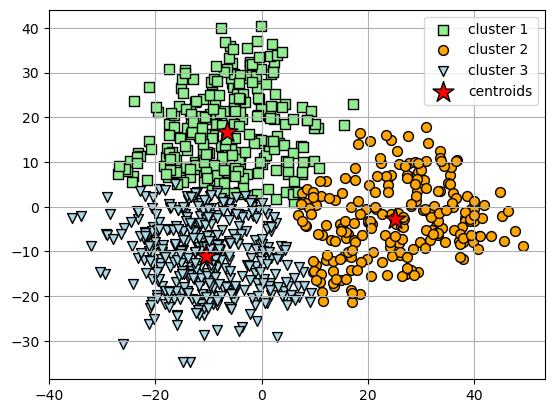

In [17]:
# plot the 3 clusters
plt.scatter(x[y_km == 0, 0], x[y_km == 0, 1], s=50, c='lightgreen', marker='s', edgecolor='black', label='cluster 1')
plt.scatter(x[y_km == 1, 0], x[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(x[y_km == 2, 0], x[y_km == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
#plt.scatter(x[y_km == 3, 0], x[y_km == 3, 1], s=50, c='yellow', marker='v', edgecolor='black', label='cluster 4')
#plt.scatter(x[y_km == 4, 0], x[y_km == 4, 1], s=50, c='magenta', marker='v', edgecolor='black', label='cluster 5')
#plt.scatter(x[y_km == 5, 0], x[y_km == 5, 1], s=50, c='darkblue', marker='v', edgecolor='black', label='cluster 6')


# plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=250, marker='*',c='red', edgecolor='black',label='centroids')
plt.legend(scatterpoints=1)
plt.grid()

/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damlas/an

Text(0, 0.5, 'Sum of squared distance')

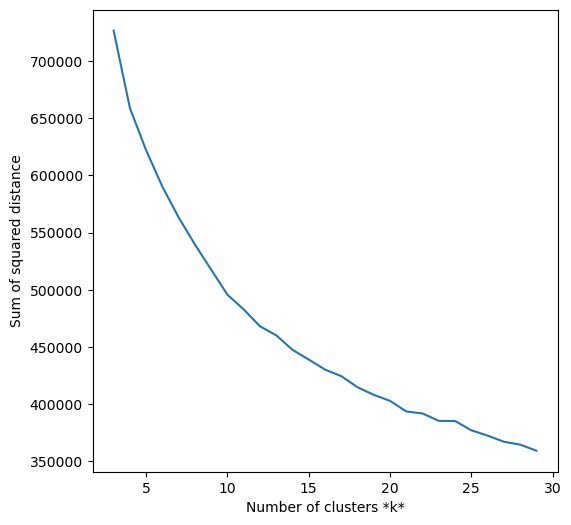

In [18]:
# this is just incase you want to see which value for k might be the best
sse = []
list_k = list(range(3, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22) #, n_jobs=-1)
    km.fit(x)

    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [19]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(feat,y_km)
print(db_index)

2.369016518650332


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.21292861


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.17796156
For n_clusters = 4 The average silhouette_score is : 0.17088342


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.1586958


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.1471599


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.13911623


/Users/damlas/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.1491691


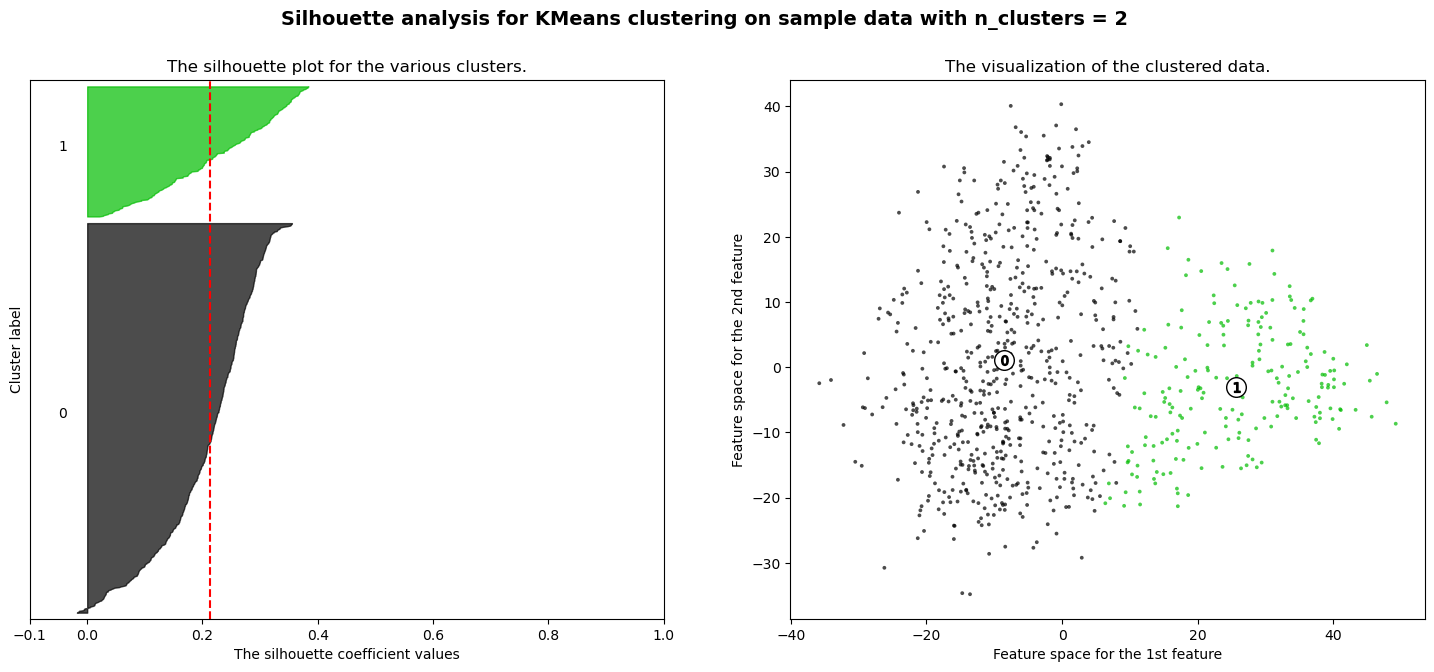

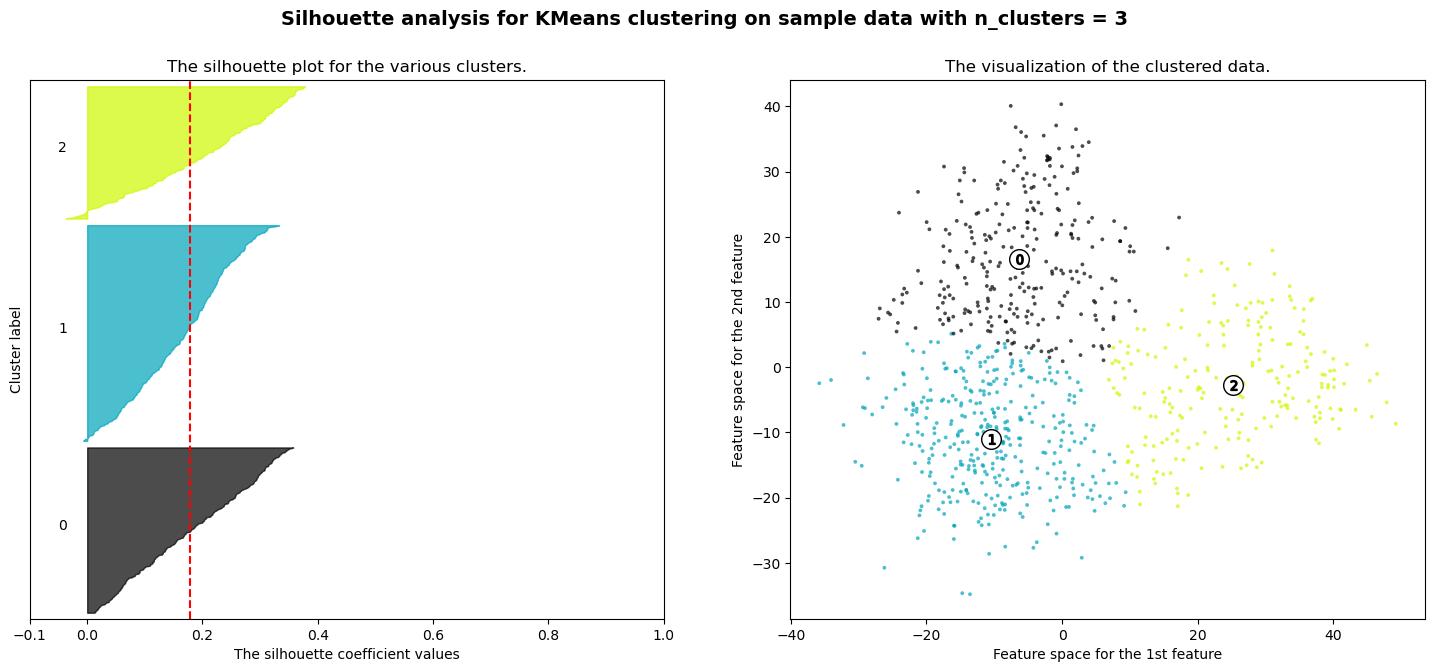

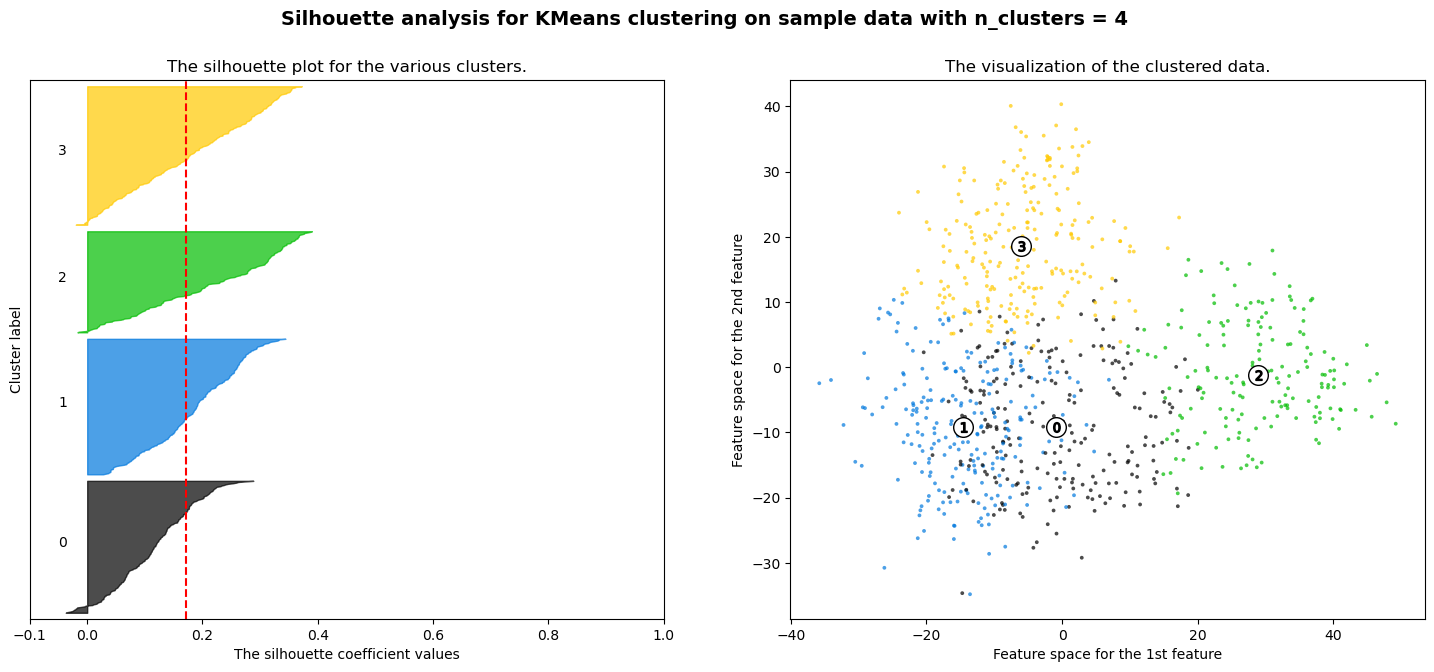

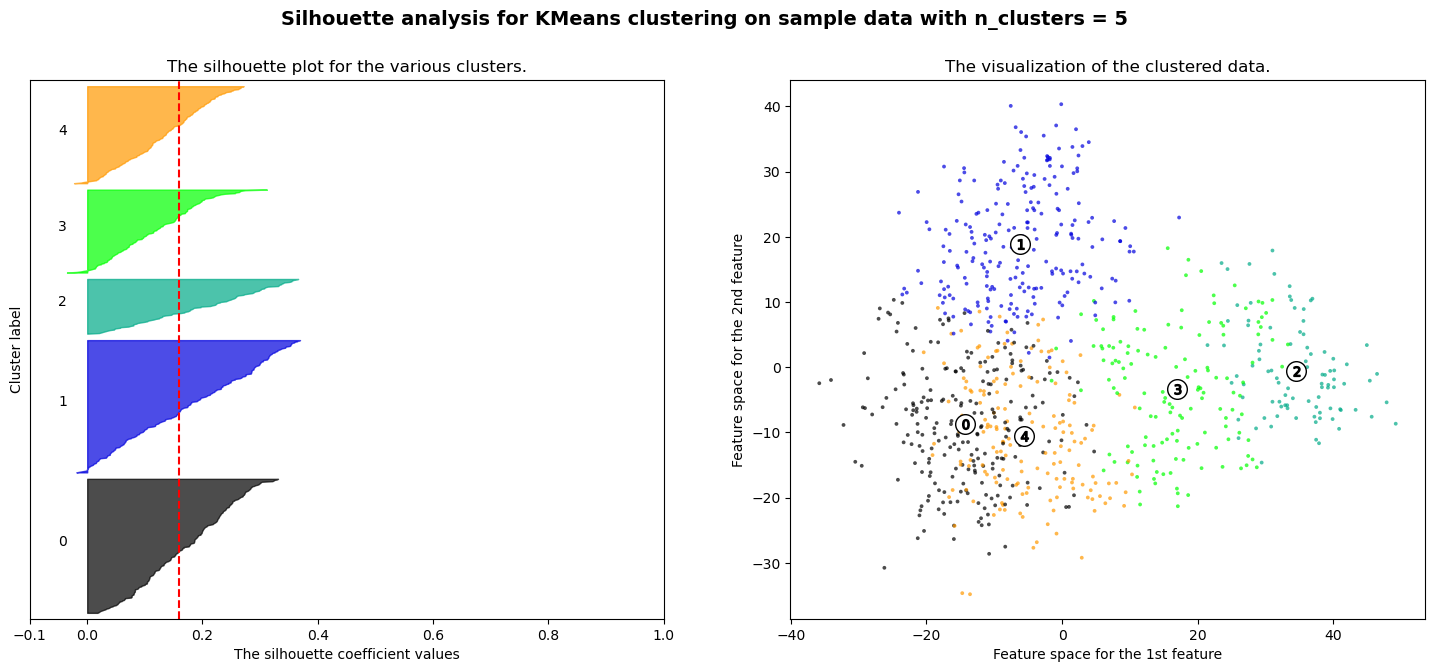

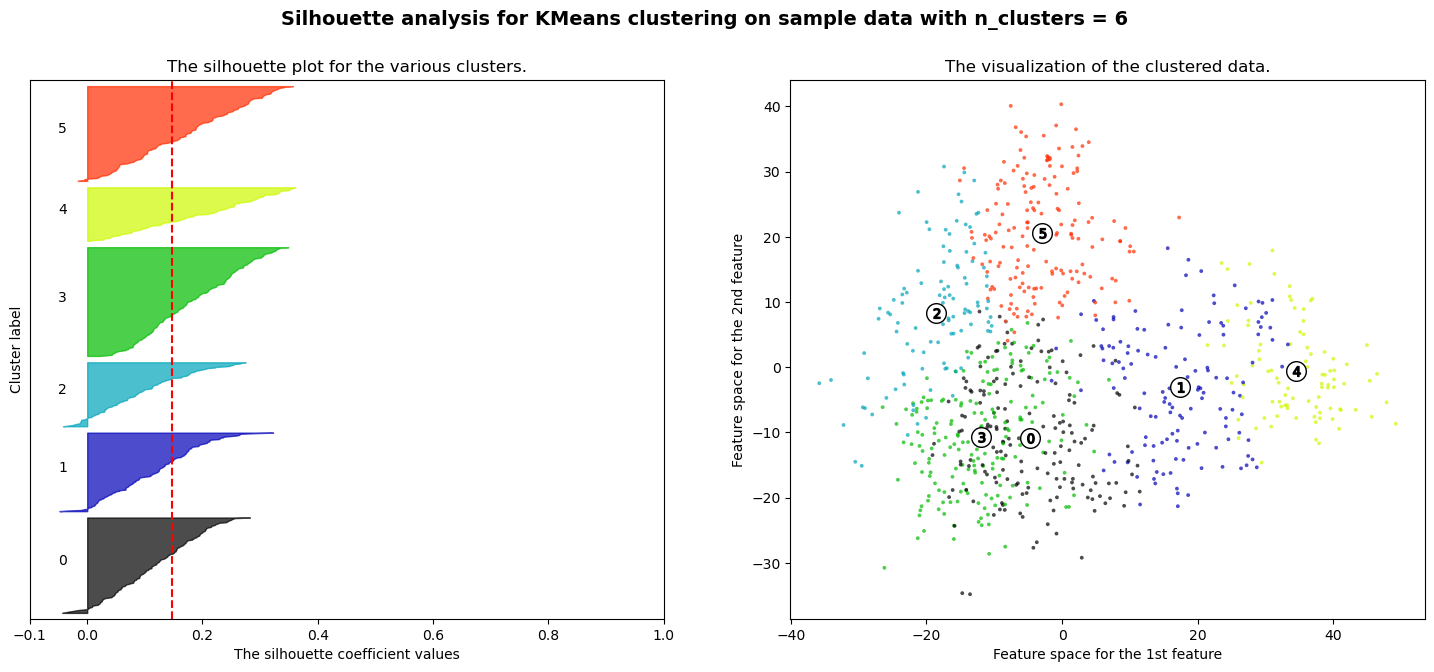

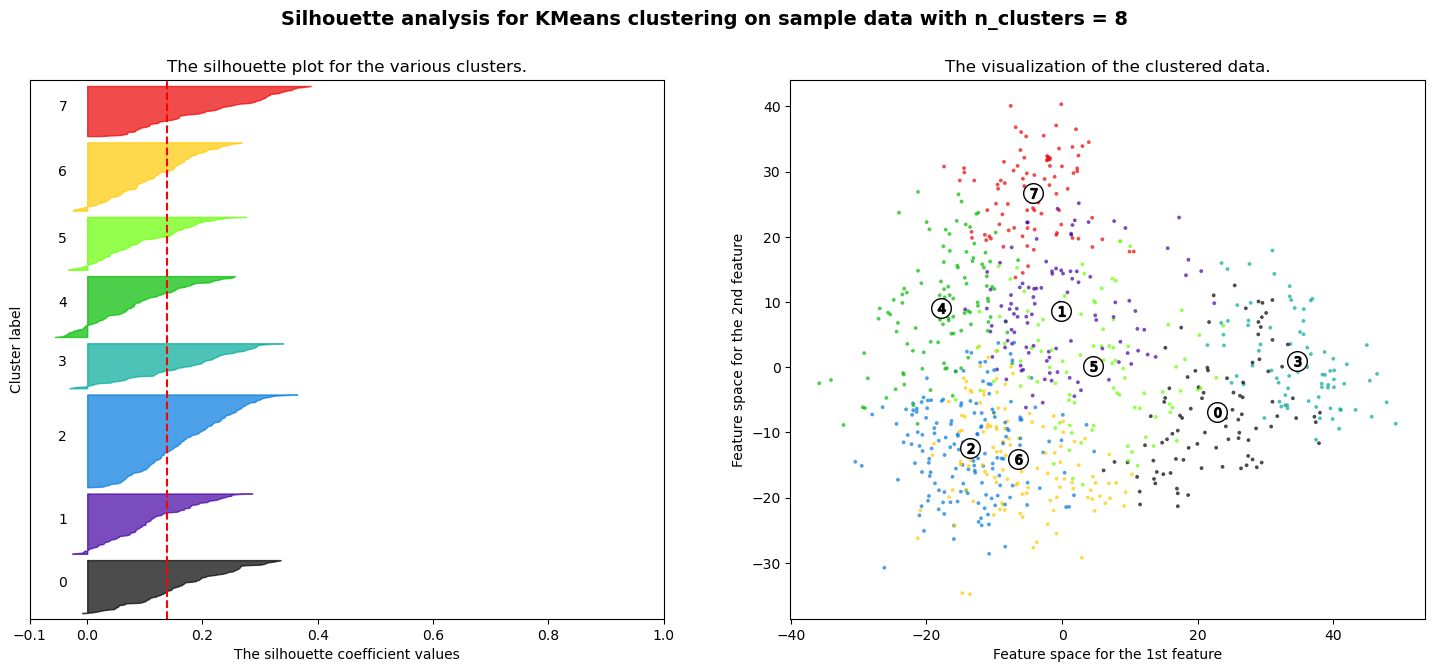

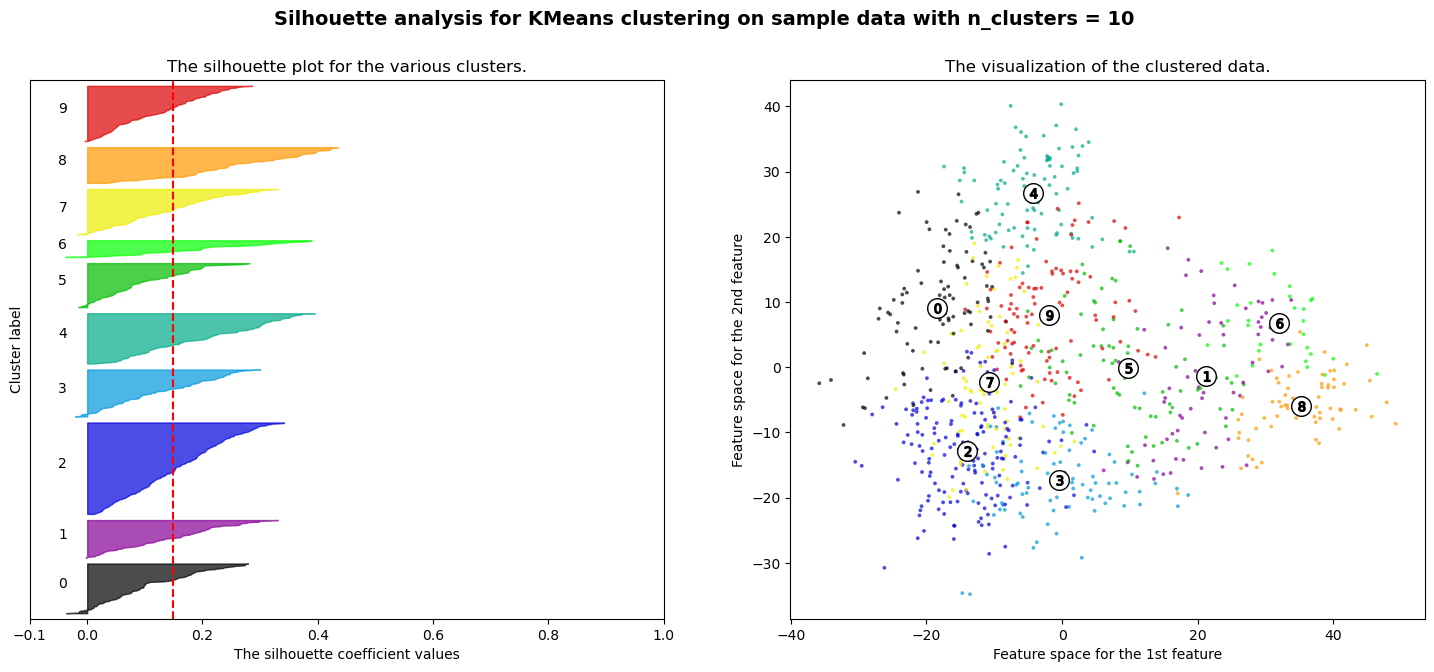

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 8, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x[:, 0], x[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()